In [1]:
import chess

import pandas as pd
import numpy as np
import random 
import math
import random

import torch

import sqlite3

Goal of the project:

Write a self learning chess AI power by a deep learning NN.


Basic Components:

The project has two main components. The first is the AI logic and model evaluation which happens in this notebook. The other part is the reinforcement learning on the neural network that happens in the other notebook. The NN is intended to be a heuristic for the value function of a given chess position. All value in chess comes from the end state reached - win, loss, or draw. A win is represented by a value of 1, a loss -1, and a draw is a 0. When one of these terminal positions is reached, the value is propagated up the tree of moves to inform the positions that led into it. The neural network attempts to capture this relationship and can be interpreted as the chance a position has of reaching a win/loss/draw from the current position. The MCTS helps bridge an important gap here by allowing values to propagate back up the decision tree of play.

In [4]:
model_num = 5

num_games = 2
num_moves = 400
simulation_length = 500

In [6]:
# From other notebook, make sure these match
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Define fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 8 * 8)
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        likelihood = torch.sigmoid(self.fc2(x))
        quality = torch.tanh(self.fc3(x))
        return quality, likelihood

Network Architecture:

Several layers of convolutional neural networks are used since the relationship between pieces at any spot in the board is typically not dependent on the exact position of the board. A different channel is used for each piece type to allow the network to learn the relationships. Ie, a pawn always captures a piece to the diagonal in front of it, regardless of where on the board it is. A black pawn captures down and a white pawn captures up, so different channels are provided for each color. The output of the network has two heads - one for the value function and another that denotes the likelihood of the position occurring. This helps inform the MCTS on what direction to evaluate play in. The likelihood output is trained on positions that have come up in game (output of 1) and randomly generated (but still possible) positions with a likelihood of 0.

In [7]:
path = f'data/Chess/model_{model_num}.pth'
model = ChessNet()
model.load_state_dict(torch.load(path))
model.eval()

ChessNet(
  (conv1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)

In [5]:
class Heuristic:
    symbol_to_channel = {
        'r': 0,
        'n': 1,
        'b': 2,
        'k': 3,
        'q': 4,
        'p': 5,
        'R': 6,
        'N': 7,
        'B': 8,
        'K': 9,
        'Q': 10,
        'P': 11
    }
    @staticmethod
    def fen_to_tensor(fen):
        array = np.zeros((12, 64))
        board = chess.Board(fen=fen)
        piece_map = board.piece_map()
        for square_num in piece_map:
            piece_type = str(piece_map[square_num])
            channel = Heuristic.symbol_to_channel[piece_type]
            array[channel][square_num] = 1
        array = array.reshape(12,8,8)
        if board.turn == chess.BLACK:
            array = np.concatenate((array[6:], array[:6]), axis=0)
            array = np.array([np.flipud(sub_array) for sub_array in array])
        return torch.tensor(array, dtype=torch.float32)
        
    def __init__(self, model):
        self.model = model

    def get_heuristic(self, fen):
        input_tensor = Heuristic.fen_to_tensor(fen)
        output = model(input_tensor)
        score = output[0] * output[1]
        return score.item()
        
class Node:
    def __init__(self, fen, heuristic, constant=1.2):
        self.fen = fen
        self.heuristic = heuristic
        self.constant = constant
        self.visits = 1
        self.value = heuristic.get_heuristic(fen)
        self.children = []
        self.terminal = False

    def get_ucb(self, parent_visits):
        # This is a value meant for the parent so you multiply by -1, value should be locked between -1 and 1
        return (self.value / self.visits * -1) + math.sqrt(math.log(parent_visits) / self.visits) * self.constant

    def get_best_child(self):
        max_weight = np.NINF
        best_child = None
        for child in self.children:
            weight = -1 * child.simulate(0)
            if weight > max_weight:
                max_weight = weight
                best_child = child
        return best_child

    def get_random_child(self):
        if len(self.children) == 1:
            return self.children[0]
        weights = []
        for child in self.children:
            weights.append(-1 * child.simulate(0))
        min_weight = min(weights)
        weights = [abs(min_weight) + weight for weight in weights]

        # Children are all draws or the exact same number
        if not any(weights):
            return random.choices(self.children)[0]
            
        child = random.choices(self.children, weights=weights)[0]
        return child
        
    def simulate(self, max_depth):
        # 1. Populate children and return max reward
        # 2. Randomly select child based on eploitation vs exploration and call simulate on it
        # 3. Decrement max_depth in case of circular movements
        # Increment visited and value every time
        
        if max_depth == 0:
            return self.value / self.visits
        else:
            max_depth -= 1
            
        if not self.children:
            board = chess.Board(self.fen)
            if board.outcome():
                if board.is_checkmate():
                    self.terminal = True
                    self.visits += 1
                    self.value = self.visits * -1
                    return -1
                else:
                    self.terminal = True
                    self.visits += 1
                    self.value = 0
                    # self.value += 0
                    return 0
            else:
                max_value = np.NINF
                for move in board.legal_moves:
                    board.push(move)
                    self.children.append(Node(board.fen(), self.heuristic))
                    board.pop()
                for child in self.children:
                    value = child.simulate(0) * -1
                    if value > max_value:
                        max_value = value
                self.value += max_value
                self.visits += 1
                return max_value
                    

        max_child = None
        max_ucb = np.NINF
        
        for child in self.children:
            ucb = child.get_ucb(self.visits)
            if ucb > max_ucb:
                max_ucb = ucb
                max_child = child

        child_value = max_child.simulate(max_depth) * -1
        self.value += child_value
        self.visits += 1
        return child_value

The evaluation loop simulates a number of chess games against itself and then saves the output to a database file. The second notebook reads in the database and uses the scores to refine the NN's accuracy. Self play then continues.

In [7]:
starting_board = chess.Board()
heuristic = Heuristic(model)

root_node = Node(starting_board.fen(), heuristic)
max_depth = np.inf

# First loop to play multiple games
for i in range(num_games):
    print(f"Starting game number {i}") 
    current_node = root_node
    # Outer loop to make moves and simulate a game
    for i in range(num_moves):        
        # Inner loop to perform monte carlo simulations
        for j in range(simulation_length):
            current_node.simulate(max_depth=max_depth)
        if current_node.terminal:
            continue
        #current_node = current_node.get_random_child()
        current_node = current_node.get_best_child()
        
        

Starting game number 0
Starting game number 1


In [8]:
# Save results in a database for training

In [9]:
conn = sqlite3.connect(f'data/Chess/training_data_{model_num}.db')
cursor = conn.cursor()

cursor.execute("CREATE TABLE IF NOT EXISTS training (fen TEXT, score REAL, likelihood REAL)")
conn.commit()

rows = []

def append_children(rows, node, parent_score):
    this_node_value = node.simulate(0)
    for child in node.children:
        append_children(rows, child, this_node_value)

    if node.visits == 1:
        return
    # If parent was winning, made a move, and now I am winning, likelihood shouldn't be the full 1.0
    # If parent was losing, made a move, and now I am losing then the parent made a good move which is okay
    # If parent had a 1 (guaranteed checkmate) and now I have a 1 (guaranteed checkmate) likelihood should be zero
    # If both scores are close to zero then likelihood should remain close to 1
    if parent_score > 0 and this_node_value > 0:
        likelihood = 1 - (parent_score + this_node_value) / 2
    else:
        likelihood = 1
    rows.append((node.fen, round(node.simulate(0), 4), round(likelihood, 4)))
    return
append_children(rows, root_node, 0)
df = pd.DataFrame(data=rows, columns=['fen', 'score', 'likelihood'])
df.to_sql('training', conn, if_exists='replace', index=False)

58829

Results:

I was able to tell a slight improvement of the model over time. I spent around 6 hours training it. I wouldn't say that the NN is particularly good at play, but this brute force propagation is able to provide insights into positions typically missed by people. The NN-based heuristic, with enough game play and fine tuning, is able to simulate the positional/creative aspect of chess and the two aspects combined make a better chess player than you'd expect. I analyzed a number of the positions and ratings reached by hand using a database browser and FEN visualization tool to make sure the network was outputting numbers that made some sort of sense most of the time. Here are some samples:

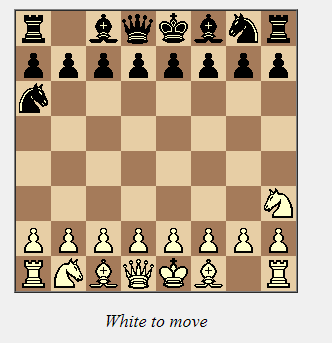

Slight edge to white. That's just chess, it's an accurate assessment. The network probably learned about white's edge from the initial dump of games since it's a statistically significant edge.

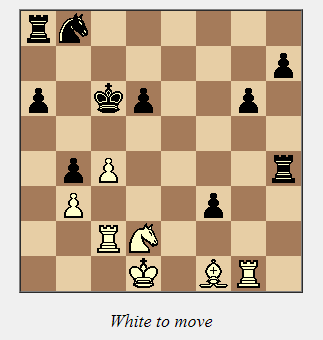

Slight edge black. I would much prefer to be white in this position, but the pair of passed pawns and active king is typically dangerous.

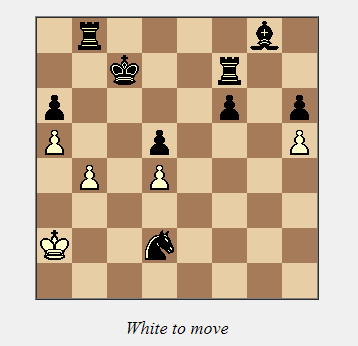

Significant edge black. This should be self explanatory, black is the only one with pieces left! These kinds of positions are good to see for sanity checks, something has gone very wrong if we're rating white as favorable here.

Overall I was impressed with the game play seen. Reasonable middle and end games were reached which shows a surface level understanding of the game. Totally random moves look much different than the positions pictured above. 